### データの読み込み

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA #主成分分析用ライブラリ
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
%matplotlib inline

# ファイルの読み込み
df = pd.read_csv('measurements.csv', sep=',')

# 先頭から5行目まで表示
display(df.head(10))

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN
5,"8,3","6,4",50,"21,5",10,NaN,E10,0,0,0,NaN,NaN
6,"7,8","4,4",43,"21,5",11,NaN,E10,0,0,0,NaN,NaN
7,"12,3",5,40,"21,5",6,NaN,E10,0,0,0,NaN,NaN
8,"4,9","6,4",26,"21,5",4,NaN,E10,0,0,0,NaN,NaN
9,"11,9","5,3",30,"21,5",9,NaN,E10,0,0,0,NaN,NaN


### カラム

#### distance
- distanceは、走行していたキロメートル単位の距離です。

#### consume
- 消費量は、ディスプレイに表示される100キロメートルあたりのリットル単位の消費量です。

#### speed
- 速度は平均速度です。

#### temp_inside
- temp_insideは加熱の設定、またはオフになっている場合は「NaN」です。

#### temp_outside
- temp_outsideは、乗車終了時に取得される外気温です。

#### specials
- 雨が降っている場合、雪が降っている場合、または気候変動が発生している場合（「AC」）は、特別事項です。

#### gas_type
- ガスタイプは、最後の補充時に使用されたガスタイプです。

#### AC
- ACは、ホットエンコードされた特別な「AC」です。 オンの場合は1、オフの場合は0。

#### rain snow
- 雨は、特別な「雨」と「雪」のワンホットエンコードです。雨/雪が降っていたので1、天気が良かったので0

#### refill liters
- 詰め替えリットル

#### refill gas
- 補充ガス

In [2]:
# データの行数・列数を確認
print(df.shape)

(388, 12)


In [3]:
# データ型を確認
print(df.dtypes)

distance         object
consume          object
speed             int64
temp_inside      object
temp_outside      int64
specials         object
gas_type         object
AC                int64
rain              int64
sun               int64
refill liters    object
refill gas       object
dtype: object


### カンマをピリオドに変換

In [4]:
# 変換
df['distance'] = df['distance'].apply(lambda x: float(x.replace(",", ".")) if type(x) is str else float(x))
df['consume'] = df['consume'].apply(lambda x: float(x.replace(",", ".")) if type(x) is str else float(x))
df['temp_inside'] = df['temp_inside'].apply(lambda x: float(x.replace(",", ".")) if type(x) is str else float(x))
df['refill liters'] = df['refill liters'].apply(lambda x: float(x.replace(",", ".")) if type(x) is str else float(x))

# 出力
display(df['distance'].head(10))
display(df['consume'].head(10))
display(df['temp_inside'].head(10))
display(df['refill liters'].head(10))

0    28.0
1    12.0
2    11.2
3    12.9
4    18.5
5     8.3
6     7.8
7    12.3
8     4.9
9    11.9
Name: distance, dtype: float64

0    5.0
1    4.2
2    5.5
3    3.9
4    4.5
5    6.4
6    4.4
7    5.0
8    6.4
9    5.3
Name: consume, dtype: float64

0    21.5
1    21.5
2    21.5
3    21.5
4    21.5
5    21.5
6    21.5
7    21.5
8    21.5
9    21.5
Name: temp_inside, dtype: float64

0    45.0
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
Name: refill liters, dtype: float64

### 欠損値の確認

In [5]:
# データ行ごとの欠損値の個数
print(df.isnull().sum(axis=1).sort_values(ascending=False))

# データ列ごとの欠損値の個数
print(df.isnull().sum(axis=0))

267    4
201    4
93     4
203    4
95     4
97     4
98     4
99     4
100    4
268    4
193    3
190    3
63     3
62     3
61     3
194    3
197    3
195    3
196    3
188    3
198    3
199    3
200    3
189    3
184    3
187    3
177    3
65     3
172    3
173    3
      ..
157    2
239    2
374    2
228    2
227    2
224    2
219    2
205    2
204    2
386    2
377    2
378    2
181    2
379    2
159    2
158    2
355    2
44     1
349    1
325    1
313    1
234    1
192    1
171    1
82     1
106    1
0      1
274    0
191    0
139    0
Length: 388, dtype: int64
distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64


In [6]:
A = np.array(df[["temp_inside","temp_outside"]])
# pca = PCA(n_components=2) #主成分分析用のオブジェクトをつくる。削減後の次元数を引数で指定する。2次元データなので、3以上にするとエラーになる
# pca.fit(X) #主成分分析の実行
X, Y, Z = np.linalg.svd(A)

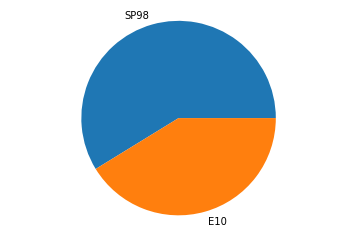

In [7]:
# 値ラベル
label = df['gas_type'].value_counts(ascending=False, normalize=True).index
# 値
vals = df['gas_type'].value_counts(ascending=False, normalize=True).values

# yの円グラフを作成
plt.pie(vals, labels=label)
plt.axis('equal')
plt.show()

### 欠損値の削除

In [8]:
# display(df)
# とりあえず欠損値が多い列を削除
df = df.drop('specials', axis=1)
df = df.drop('refill liters', axis=1)
df = df.drop('refill gas', axis=1)

# display(df)
print(df.shape)

(388, 9)


### 欠損値の補完

In [9]:
# data['Age'].fillna(data['Age'].mean())   # 列Ageの欠損値をAgeの平均値で穴埋め
# data['Age'].fillna(data['Age'].median()) # 列Ageの欠損値をAgeの中央値で穴埋め
# data['Age'].fillna(data['Age'].mode())   # 列Ageの欠損値をAgeの最頻値で穴埋め
# data.fillna(method = 'ffill') # 一個前の値で穴埋め
# data.fillna(method = 'bfill') # 一個次の値で穴埋め

df['temp_inside'] = df['temp_inside'].fillna(df['temp_inside'].mean())
# df = df.fillna(method='ffill')
# df['refill liters'] = df['refill liters'].fillna(0)
# df['refill gas'] = df['refill gas'].fillna('NAN')

# # データ行ごとの欠損値の個数
# print(df.isnull().sum(axis=1).sort_values(ascending=False))
# # データ列ごとの欠損値の個数
# print(df.isnull().sum(axis=0))
display(df)

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28.0,5.0,26,21.5,12,E10,0,0,0
1,12.0,4.2,30,21.5,13,E10,0,0,0
2,11.2,5.5,38,21.5,15,E10,0,0,0
3,12.9,3.9,36,21.5,14,E10,0,0,0
4,18.5,4.5,46,21.5,15,E10,0,0,0
5,8.3,6.4,50,21.5,10,E10,0,0,0
6,7.8,4.4,43,21.5,11,E10,0,0,0
7,12.3,5.0,40,21.5,6,E10,0,0,0
8,4.9,6.4,26,21.5,4,E10,0,0,0
9,11.9,5.3,30,21.5,9,E10,0,0,0


In [10]:
A = np.array(df[["temp_inside","temp_outside"]])
# pca = PCA(n_components=2) #主成分分析用のオブジェクトをつくる。削減後の次元数を引数で指定する。2次元データなので、3以上にするとエラーになる
# pca.fit(X) #主成分分析の実行
X, Y, Z = np.linalg.svd(A)

### ダミー変数化

In [11]:
# sp98を1、E10を0へ置換
# df = df.replace('E10', 0)
# df = df.replace('SP98', 1)
df['gas_type'] = df['gas_type'].replace("E10", 0)
df['gas_type'] = df['gas_type'].replace("SP98", 1)
# df['refill gas'] = df['refill gas'].replace("E10", 1)
# df['refill gas'] = df['refill gas'].replace("SP98", 1)
# df['refill gas'] = df['refill gas'].replace("NAN", 0)

display(df)

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28.0,5.0,26,21.5,12,0,0,0,0
1,12.0,4.2,30,21.5,13,0,0,0,0
2,11.2,5.5,38,21.5,15,0,0,0,0
3,12.9,3.9,36,21.5,14,0,0,0,0
4,18.5,4.5,46,21.5,15,0,0,0,0
5,8.3,6.4,50,21.5,10,0,0,0,0
6,7.8,4.4,43,21.5,11,0,0,0,0
7,12.3,5.0,40,21.5,6,0,0,0,0
8,4.9,6.4,26,21.5,4,0,0,0,0
9,11.9,5.3,30,21.5,9,0,0,0,0


In [12]:
# 散布図行列を書いてみる
# pd.plotting.scatter_matrix(df, figsize=(20,20))
# plt.show()

In [13]:
# df.corr().style.background_gradient("autumn_r")

### 統計量の計算

In [14]:
# データ型が数値項目の各種統計量の計算
display(df.describe())

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.929521,11.358247,0.587629,0.077320,0.123711,0.082474
std,22.667837,1.033172,13.598524,0.994666,6.991542,0.492897,0.267443,0.329677,0.275441
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,1.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000


## 学習

### 線形回帰

In [15]:
# ホールドアウト法
y = df["consume"]
X = df.drop(["consume"], axis=1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

# 重みを取り出す
# w0 = regr.intercept_
# w1 = regr.coef_[0]
# w2 = regr.coef_[1]
# w3 = regr.coef_[2]
# w4 = regr.coef_[3]
# w5 = regr.coef_[4]
# w6 = regr.coef_[5]
# w7 = regr.coef_[6]
# w8 = regr.coef_[7]
# # w9 = regr.coef_[8]
# # w10 = regr.coef_[9]

# # 説明変数
# x1 = df_train['distance'].values
# x2 = df_train['speed'].values
# x3 = df_train['temp_inside'].values
# x4 = df_train['temp_outside'].values
# x5 = df_train['gas_type'].values
# x6 = df_train['AC'].values
# x7 = df_train['rain'].values
# x8 = df_train['sun'].values
# # x9 = df_train['refill liters'].values
# # x10 = df_train['refill gas'].values

# # 重みと二乗誤差の確認
# # y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3 + w4 * x4 + w5 * x5 + w6 * x6 + x7 * x7 + x8 * w8 + x9 * w9 + x10 * w10
# y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3 + w4 * x4 + w5 * x5 + w6 * x6 + x7 * x7 + x8 * w8
# squared_error = 0.5 * np.sum((y_train - y_est) ** 2)
# # print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}, w9 = {:.3f}, w10 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10))
# print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}, w7 = {:.3f}, w8 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6, w7, w8))

# print('二乗誤差 = {:.3f}'.format(squared_error))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### テストデータで評価

In [16]:
# 値を予測
y_pred = regr.predict(X_test)

# MSEを計算
mse = mean_squared_error(y_test, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_test, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.676
MAE = 0.666
RMSE = 0.822


#### 訓練データで評価

In [17]:
# 値を予測
y_pred = regr.predict(X_train)

# MSEを計算
mse = mean_squared_error(y_train, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_train, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.891
MAE = 0.616
RMSE = 0.944


In [18]:
estimator = LinearRegression(fit_intercept=True)

# 50から350まで50刻みで検証する
# train_sizes = np.arange(0, 206, 20)

# cvにintを渡すと k-foldの「k」を指定できる
# ↓では3にしているので、3-fold法を使用する。
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train, y_train, cv=3, scoring="neg_mean_squared_error", random_state=1234, shuffle=True
)

print("train_sizes(検証したサンプル数): {}".format(train_sizes))
print("------------")
print("train_scores(各サンプル数でのトレーニングスコア): \n{}".format(train_scores))
print("------------")
print("test_scores(各サンプル数でのバリデーションスコア): \n{}".format(test_scores))

train_sizes(検証したサンプル数): [ 20  66 113 159 206]
------------
train_scores(各サンプル数でのトレーニングスコア): 
[[-0.98904453 -0.24700472 -0.96504655]
 [-1.08099731 -0.50833035 -1.66164017]
 [-0.87481565 -0.46102965 -1.22775603]
 [-0.87992649 -0.6682788  -1.15959233]
 [-0.94876107 -0.61455586 -1.05825962]]
------------
test_scores(各サンプル数でのバリデーションスコア): 
[[-1.20588084 -2.84121802 -1.32087524]
 [-0.8829284  -2.03760065 -0.81981534]
 [-0.7984717  -1.75759377 -0.73679015]
 [-0.81092327 -1.6357534  -0.69657419]
 [-0.81118798 -1.56899954 -0.60787327]]


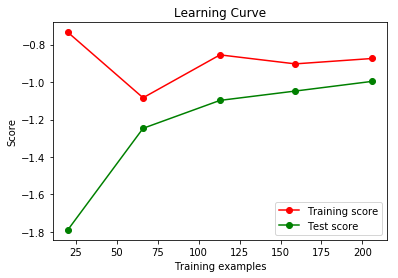

In [19]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

# Traing score と Test score をプロット
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

# 標準偏差の範囲を色付け
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.2)

# plt.ylim(0.85, 1.0)
plt.legend(loc="best")

plt.show()

### ステップワイズ

In [20]:
# estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
estimator = LinearRegression(normalize=False)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='neg_mean_absolute_error')

In [21]:
# fitで特徴選択を実行
rfecv.fit(X, y)

RFECV(cv=10,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
   n_jobs=1, scoring='neg_mean_absolute_error', step=1, verbose=0)

In [22]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[3 2 1 1 1 1 1 1]


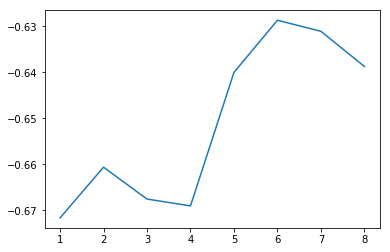

In [23]:
# 特徴数とスコアの変化をプロット
# 負のMAEが評価基準になっており，値がゼロに近いほど汎化誤差は小さい
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [24]:
# rfecv.support_でランキング1位以外はFalseとするindexを取得できる
# Trueになっている特徴を使用すれば汎化誤差は最小となる
rfecv.support_

array([False, False,  True,  True,  True,  True,  True,  True])

In [25]:
# bool型の配列に ~ をつけるとTrueとFalseを反転させることができる
# ここでTrueになっている特徴が削除してもよい特徴
remove_idx = ~rfecv.support_
remove_idx

array([ True,  True, False, False, False, False, False, False])

In [26]:
# 削除してもよい特徴の名前を取得する
remove_feature = X.columns[remove_idx]
remove_feature

Index(['distance', 'speed'], dtype='object')

In [27]:
# drop関数で特徴を削除
selected_train_data = X.drop(remove_feature, axis=1)

In [28]:
# ホールドアウト法
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(selected_train_data, y, test_size=test_size, random_state=1234)

regr = LinearRegression(fit_intercept=True)
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### テストデータで評価

In [29]:
# 値を予測
y_pred = regr.predict(X_test)

# MSEを計算
mse = mean_squared_error(y_test, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_test, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.67
MAE = 0.662
RMSE = 0.818


#### 訓練データで評価

In [30]:
# 値を予測
y_pred = regr.predict(X_train)

# MSEを計算
mse = mean_squared_error(y_train, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_train, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.954
MAE = 0.601
RMSE = 0.977


In [31]:
estimator = LinearRegression(fit_intercept=True)

# 50から350まで50刻みで検証する
# train_sizes = np.arange(0, 206, 20)

# cvにintを渡すと k-foldの「k」を指定できる
# ↓では3にしているので、3-fold法を使用する。
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train, y_train, cv=3, scoring="neg_mean_squared_error", random_state=1234, shuffle=True
)

print("train_sizes(検証したサンプル数): {}".format(train_sizes))
print("------------")
print("train_scores(各サンプル数でのトレーニングスコア): \n{}".format(train_scores))
print("------------")
print("test_scores(各サンプル数でのバリデーションスコア): \n{}".format(test_scores))



train_sizes(検証したサンプル数): [ 20  66 113 159 206]
------------
train_scores(各サンプル数でのトレーニングスコア): 
[[-1.16729773 -0.3578674  -1.07793054]
 [-1.16758718 -0.54800739 -1.79837557]
 [-0.96622813 -0.50119573 -1.28674596]
 [-0.97797234 -0.70979435 -1.27153385]
 [-1.05361632 -0.63610215 -1.13445014]]
------------
test_scores(各サンプル数でのバリデーションスコア): 
[[-0.842174   -2.23092991 -1.53955189]
 [-0.90541322 -1.98206681 -0.87391342]
 [-0.7308725  -1.79065756 -0.78387478]
 [-0.7389252  -1.7782379  -0.70666207]
 [-0.77079247 -1.6879659  -0.63473614]]


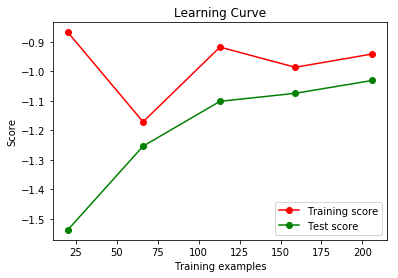

In [32]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

# Traing score と Test score をプロット
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

# 標準偏差の範囲を色付け
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.2)

# plt.ylim(0.85, 1.0)
plt.legend(loc="best")

plt.show()

## 以下別のモデルで検証

### 決定木回帰

In [33]:
# ホールドアウト法
y = df["consume"]
X = df.drop(["consume"], axis=1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

detr = DecisionTreeRegressor(max_depth=2, min_samples_split=2)
detr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [34]:
# 値を予測
y_pred = detr.predict(X_test)

# MSEを計算
mse = mean_squared_error(y_test, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_test, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.845
MAE = 0.663
RMSE = 0.919


train_sizes(検証したサンプル数): [ 20  66 113 159 206]
------------
train_scores(各サンプル数でのトレーニングスコア): 
[[-0.12582778 -0.1502619  -0.243     ]
 [-0.30115782 -0.18662018 -0.34048277]
 [-0.32917203 -0.29799603 -0.41467446]
 [-0.33348236 -0.36921334 -0.5095631 ]
 [-0.39882096 -0.34801635 -0.5041612 ]]
------------
test_scores(各サンプル数でのバリデーションスコア): 
[[-0.61214176 -1.31944417 -4.21070119]
 [-0.62343649 -1.58088304 -0.64902754]
 [-0.61583685 -1.658267   -0.70662806]
 [-0.61710343 -0.84126592 -0.44328743]
 [-0.60881051 -0.83881463 -0.58810797]]


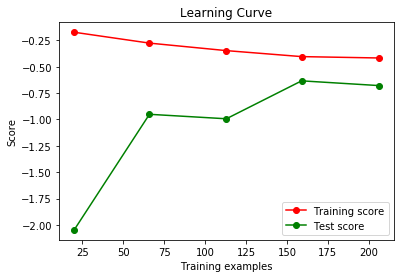

In [35]:
estimator = DecisionTreeRegressor(max_depth=2, min_samples_split=2)

# 50から350まで50刻みで検証する
# train_sizes = np.arange(0, 206, 20)

# cvにintを渡すと k-foldの「k」を指定できる
# ↓では3にしているので、3-fold法を使用する。
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train, y_train, cv=3, scoring="neg_mean_squared_error", random_state=1234, shuffle=True
)

print("train_sizes(検証したサンプル数): {}".format(train_sizes))
print("------------")
print("train_scores(各サンプル数でのトレーニングスコア): \n{}".format(train_scores))
print("------------")
print("test_scores(各サンプル数でのバリデーションスコア): \n{}".format(test_scores))



train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

# Traing score と Test score をプロット
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

# 標準偏差の範囲を色付け
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.2)

# plt.ylim(0.85, 1.0)
plt.legend(loc="best")

plt.show()

### ランダムフォレスト回帰

In [36]:
# ホールドアウト法
y = df["consume"]
X = df.drop(["consume"], axis=1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

rafr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=2, min_samples_leaf=2)
rafr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [37]:
# 値を予測
y_pred = rafr.predict(X_test)

# MSEを計算
mse = mean_squared_error(y_test, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_test, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.58
MAE = 0.596
RMSE = 0.761


train_sizes(検証したサンプル数): [ 20  66 113 159 206]
------------
train_scores(各サンプル数でのトレーニングスコア): 
[[-0.75979213 -0.38925694 -1.16443289]
 [-0.45020601 -0.23797868 -0.36497712]
 [-0.32597271 -0.26787695 -0.41447528]
 [-0.33175257 -0.34358386 -0.44595354]
 [-0.39880343 -0.33549129 -0.4368432 ]]
------------
test_scores(各サンプル数でのバリデーションスコア): 
[[-0.72436011 -1.38824816 -0.61464684]
 [-0.42715515 -1.16924016 -0.48622065]
 [-0.47764095 -1.42655628 -0.48834725]
 [-0.54504461 -0.84751538 -0.44222553]
 [-0.56301075 -0.90325086 -0.46436262]]


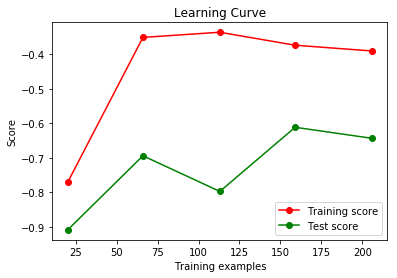

In [38]:
estimator = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=2, min_samples_leaf=2)

# 50から350まで50刻みで検証する
# train_sizes = np.arange(0, 206, 20)

# cvにintを渡すと k-foldの「k」を指定できる
# ↓では3にしているので、3-fold法を使用する。
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train, y_train, cv=3, scoring="neg_mean_squared_error", random_state=1234, shuffle=True
)

print("train_sizes(検証したサンプル数): {}".format(train_sizes))
print("------------")
print("train_scores(各サンプル数でのトレーニングスコア): \n{}".format(train_scores))
print("------------")
print("test_scores(各サンプル数でのバリデーションスコア): \n{}".format(test_scores))



train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

# Traing score と Test score をプロット
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

# 標準偏差の範囲を色付け
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.2)

# plt.ylim(0.85, 1.0)
plt.legend(loc="best")

plt.show()

### サポートベクター回帰

In [39]:
# ホールドアウト法
y = df["consume"]
X = df.drop(["consume"], axis=1)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [40]:
# 値を予測
y_pred = svr.predict(X_test)

# MSEを計算
mse = mean_squared_error(y_test, y_pred) 
print("MSE = %s"%round(mse,3) )  

# MAEを計算
mae = mean_absolute_error(y_test, y_pred) 
print("MAE = %s"%round(mae,3) )

# RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

MSE = 0.508
MAE = 0.553
RMSE = 0.713


train_sizes(検証したサンプル数): [ 20  66 113 159 206]
------------
train_scores(各サンプル数でのトレーニングスコア): 
[[-0.9152319  -0.45168123 -1.98979806]
 [-0.80044595 -0.23727922 -1.37185676]
 [-0.50193516 -0.16507737 -0.87479674]
 [-0.52423728 -0.28500818 -0.74586457]
 [-0.55540269 -0.23023233 -0.60071635]]
------------
test_scores(各サンプル数でのバリデーションスコア): 
[[-0.89028917 -1.98051096 -0.70165858]
 [-0.78213458 -1.93759423 -0.63315077]
 [-0.76071135 -1.80248138 -0.62185525]
 [-0.72431882 -1.78946418 -0.55790402]
 [-0.70030291 -1.78291886 -0.54806151]]


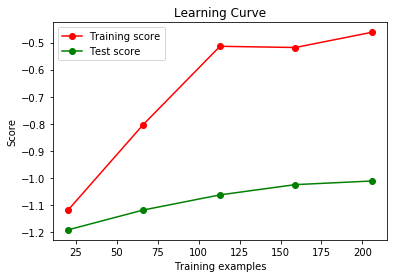

In [41]:
estimator = SVR(kernel='rbf')

# 50から350まで50刻みで検証する
# train_sizes = np.arange(0, 206, 20)

# cvにintを渡すと k-foldの「k」を指定できる
# ↓では3にしているので、3-fold法を使用する。
train_sizes, train_scores, test_scores = learning_curve(
    estimator, X_train, y_train, cv=3, scoring="neg_mean_squared_error", random_state=1234, shuffle=True
)

print("train_sizes(検証したサンプル数): {}".format(train_sizes))
print("------------")
print("train_scores(各サンプル数でのトレーニングスコア): \n{}".format(train_scores))
print("------------")
print("test_scores(各サンプル数でのバリデーションスコア): \n{}".format(test_scores))



train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

# Traing score と Test score をプロット
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Test score")

# 標準偏差の範囲を色付け
# plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, color="r", alpha=0.2)
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, color="g", alpha=0.2)

# plt.ylim(0.85, 1.0)
plt.legend(loc="best")

plt.show()